In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

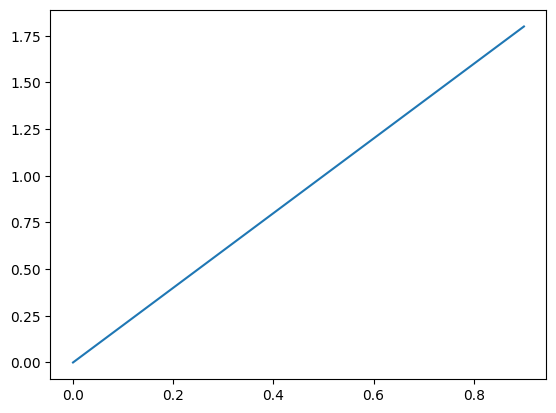

In [2]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [2]:
import h5py

In [3]:
from scipy.stats import norm

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [16]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes')

In [5]:
import torch.nn.functional as F

In [6]:
epochs_wsl = 100;

In [7]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# 4-AE + WSL

## Networks

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [43]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 8)
        self.norm2 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        x = self.norm2(self.relu(self.fc2(x)))
        return self.fc4(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [9]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
ae = AutoEncoder().cuda()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

8302


In [11]:
wsc = WSClassifier().cuda()
print(sum(p.numel() for p in wsc.parameters() if p.requires_grad))

6593


In [16]:
wsc

WSClassifier(
  (fc1): Linear(in_features=101, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

## data loading

In [12]:
list_datatype = ["noise", "bbh", "sg", "glitch"]

In [96]:
N_wsl_total = 30000;
N_wsl = {}
N_wsl["noise"] = int(0.75*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sg"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)

In [97]:
renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [98]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

In [99]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
realsg_reserved = realsg[-int(0.2 * len(realsg)):]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
realbbh = realbbh[:-int(0.2 * len(realbbh))]
realsg = realsg[:-int(0.2 * len(realsg))]
realglitch = realglitch[:-int(0.2 * len(realglitch))]

In [100]:
bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(realbbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(realsg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(realglitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [101]:
bkg_fft.shape

(112000, 101)

In [102]:
glitch_fft.shape

(96000, 101)

In [103]:
bkg_fft = bkg_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)

sg_fft = sg_fft.reshape(-1,202)

glitch_fft = glitch_fft.reshape(-1,202)

In [15]:
# dataset_raw = {};
# dataset_raw["noise"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'].reshape(-1,200);
# dataset_raw["bbh"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy").reshape(-1,200);
# dataset_raw["sg"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy").reshape(-1,200);
# # realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
# dataset_raw["glitch"] = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# dataset_wsl = {};
# dataset_ae = {};
# dataset_wsl_fft = {};
# dataset_ae_fft = {};

# for dt in list_datatype:
#     perm = np.random.permutation(len(dataset_raw[dt]))
#     nwsl = N_wsl[dt]
#     dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
#     dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
#     dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
#     dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
#     dataset_ae[dt]  = dataset_raw[dt][perm[nwsl:]]
#     dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
#     dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
#     dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
#     np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det.dat", perm)

In [104]:
dataset_raw_fft = {}

dataset_raw_fft["noise"] = bkg_fft
dataset_raw_fft["bbh"] = bbh_fft
dataset_raw_fft["sg"] = sg_fft
dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    nwsl = N_wsl[dt]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det.dat", perm)

In [105]:
np.linalg.norm(dataset_ae_fft['noise'][0])

1.4142135623730951

In [106]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(33500, 202)
bbh
(77000, 202)
sg
(77000, 202)
glitch
(46500, 202)


In [25]:
for key in dataset_wsl.keys():
    print(key)
    print(dataset_wsl[key].shape)

In [142]:
realbkg_reserved.shape

(28000, 200)

In [143]:
bkg_reserved_fft = abs(np.fft.rfft(realbkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_reserved_fft = abs(np.fft.rfft(realbbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_reserved_fft = abs(np.fft.rfft(realsg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_reserved_fft = abs(np.fft.rfft(realglitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [145]:
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)

In [149]:
bkg_reserved_fft.shape

(14000, 202)

In [298]:
N_reserved_test = {}

N_reserved_test_total = 20000

N_reserved_test['glitch'] = int(0.05 * N_reserved_test_total)
N_reserved_test['noise'] = int(0.15 * N_reserved_test_total)
N_reserved_test['bbh'] = int(0.15 * N_reserved_test_total)
N_reserved_test['sg'] = int(0.65 * N_reserved_test_total)

dataset_reserved_test_collected = np.vstack((glitch_reserved_fft[-N_reserved_test['glitch']:], bkg_reserved_fft[-N_reserved_test['noise']:],
                                             bbh_reserved_fft[-N_reserved_test['bbh']:], sg_reserved_fft[-N_reserved_test['sg']:]))

In [299]:
dataset_reserved_test_collected.shape

(20000, 202)

In [300]:
random.choice()

TypeError: Random.choice() missing 1 required positional argument: 'seq'

## training

In [26]:
version = "v5";

In [27]:
epochs = 50;

In [28]:
sequence = ["glitch", "noise", "bbh", "sg"];
ind2datatype = {};
datatype2ind = {};
for i, dt in enumerate(sequence):
    ind2datatype[i] = dt;
    datatype2ind[dt] = i;
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/WSL/sequence_"+version+".json")

In [107]:
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [30]:
# N_bkg = len(bkg_reserved_fft);
# N_glitch = int(N_bkg/15);
# N_bbh = int(N_bkg*2/15);
# N_sg = int(N_bkg*2/15);

# testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

# s = 0;
# testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
# s += N_glitch;

# testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
# s += N_bkg;

# testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
# s += N_bbh;

# testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
# s += N_sg;

# correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

# Nsample = {};
# Nsample["glitch"] = N_glitch;
# Nsample["noise"] = N_bkg;
# Nsample["bbh"] = N_bbh;
# Nsample["sg"] = N_sg

In [31]:
# Ncut = 5;
# cutList = {};

# max_glitch = 0.0026;
# min_glitch = 0.001;
# cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

# max_bkg = 0.0026;
# min_bkg = 0.001;
# cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

# max_bbh = 0.0024;
# min_bbh = 0.0008;
# cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

# max_sg = 0.003;
# min_sg = 0.0003;
# cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

# torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [32]:
Ncut = 5;
cutList = {};

max_glitch = 0.0014;
min_glitch = 0.0024;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0016;
min_bkg = 0.0026;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [33]:
# models = {};
# models["glitch"] = torch.load("../Model_cached/4ae_3.pt")
# models["glitch"].cpu().eval()

In [34]:
models = {};
models["glitch"] = torch.load("../Model_cached/2_det_oneglitchonenoise_trained.pt")
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [35]:
def trainAE(dataset, cutID):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_1.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [36]:
def trainWSC(dataset0, dataset1, cutID):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_1.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [37]:
model1 = trainWSC(dataset0, dataset1, "test").cpu().eval();

NameError: name 'dataset0' is not defined

In [38]:
import itertools

In [69]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[3] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 84:
        continue
    elif cnt > 85:
        continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
    for iPrev in range(3):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        model = trainWSC(dataset0, dataset1, cutID)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    
    
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
84
887.0087673664093
dict_keys(['glitch', 'glitch_WSC', 'noise', 'noise_WSC', 'bbh', 'bbh_WSC', 'sg'])
85
918.9777042865753


In [175]:
testset = dataset_wsl_fft_collected

In [176]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sg']))

Below is only concerning the TPR-FPR analysis

In [301]:
testset = dataset_reserved_test_collected

In [302]:
testset.shape

(20000, 202)

In [303]:
correct_ans = np.hstack(([0]*N_reserved_test['glitch'], [1]*N_reserved_test['noise'], [2]*N_reserved_test['bbh'], [3]*N_reserved_test['sg']))

In [304]:
correct_ans.shape

(20000,)

In [76]:
ic[3] = 0

In [227]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))
listResult['FPR'] = np.empty((Ncut**(len(list_datatype)-1), 1))
listResult['total_accuracy'] = np.empty((Ncut**(len(list_datatype)-1), 1))
cnt = 0


for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    for iStep in range(len(list_datatype)):
        datatype = ind2datatype[iStep];
        if datatype == 'sg':
            ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
        else:
            ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
            
        if datatype == 'noise':
            ind_pass_fprcalc = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
            # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
            noise_number = np.sum(np.logical_and(not_select, correct_ans == 1))
            passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass_fprcalc, correct_ans == 1))
            listResult['FPR'][cnt] = passed_noise_number / noise_number
            print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
        
        ans[ind_pass] = iStep;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;

    listResult["cut"][cnt] = ic;
    listResult["ans"][cnt] = ans;

    acc = np.zeros(len(ind2datatype));

    for i in range(len(ind2datatype)):
        acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/N_wsl[ind2datatype[i]];
        
    listResult["accuracy_4"][cnt] = acc;

    listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
                                        np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 5702 noise events passed the glitch WSL, and 23 noise events within the threshold for TPR=0.9
For cnt = 1, totally 5641 noise events passed the glitch WSL, and 17 noise events within the threshold for TPR=0.9
For cnt = 2, totally 5688 noise events passed the glitch WSL, and 23 noise events within the threshold for TPR=0.9
For cnt = 3, totally 5719 noise events passed the glitch WSL, and 22 noise events within the threshold for TPR=0.9


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_11852\3317973674.py:111: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]),
C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_11852\3317973674.py:112: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]


For cnt = 4, totally 5721 noise events passed the glitch WSL, and 20 noise events within the threshold for TPR=0.9
For cnt = 5, totally 5488 noise events passed the glitch WSL, and 46 noise events within the threshold for TPR=0.9
For cnt = 6, totally 5471 noise events passed the glitch WSL, and 51 noise events within the threshold for TPR=0.9
For cnt = 7, totally 5529 noise events passed the glitch WSL, and 40 noise events within the threshold for TPR=0.9
For cnt = 8, totally 5557 noise events passed the glitch WSL, and 44 noise events within the threshold for TPR=0.9
For cnt = 9, totally 5694 noise events passed the glitch WSL, and 60 noise events within the threshold for TPR=0.9
For cnt = 10, totally 5701 noise events passed the glitch WSL, and 72 noise events within the threshold for TPR=0.9
For cnt = 11, totally 5522 noise events passed the glitch WSL, and 99 noise events within the threshold for TPR=0.9
For cnt = 12, totally 5696 noise events passed the glitch WSL, and 81 noise ev

In [228]:
testset.shape

(20000, 202)

# Roburtness check

In [305]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))
listResult['FPR'] = np.empty((Ncut**(len(list_datatype)-1), 1))
listResult['total_accuracy'] = np.empty((Ncut**(len(list_datatype)-1), 1))
cnt = 0


for ic[0], ic[1], ic[2] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
    
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    for iStep in range(len(list_datatype)):
        datatype = ind2datatype[iStep];
        if datatype == 'sg':
            ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
        else:
            ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
            
        if datatype == 'noise':
            ind_pass_fprcalc = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_reserved_test['bbh']-N_reserved_test['sg']:])[int(0.1 * (N_reserved_test['bbh']+N_reserved_test['sg']))])
            # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
            noise_number = np.sum(np.logical_and(not_select, correct_ans == 1))
            passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass_fprcalc, correct_ans == 1))
            listResult['FPR'][cnt] = passed_noise_number / noise_number
            print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
        
        ans[ind_pass] = iStep;
        not_select[ind_pass] = False;
        
    ans[not_select] = -1;

    listResult["cut"][cnt] = ic;
    listResult["ans"][cnt] = ans;

    acc = np.zeros(len(ind2datatype));

    for i in range(len(ind2datatype)):
        acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/N_reserved_test[ind2datatype[i]];
        
    listResult["accuracy_4"][cnt] = acc;

    listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_reserved_test[dtype] for dtype in ["glitch", "noise"])/np.sum(N_reserved_test[dtype] for dtype in ["glitch", "noise"]), 
                                        np.sum(acc[datatype2ind[dtype]]*N_reserved_test[dtype] for dtype in ["bbh", "sg"])/np.sum(N_reserved_test[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;
    
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

For cnt = 0, totally 2865 noise events passed the glitch WSL, and 16 noise events within the threshold for TPR=0.9
For cnt = 1, totally 2827 noise events passed the glitch WSL, and 7 noise events within the threshold for TPR=0.9
For cnt = 2, totally 2847 noise events passed the glitch WSL, and 9 noise events within the threshold for TPR=0.9
For cnt = 3, totally 2861 noise events passed the glitch WSL, and 10 noise events within the threshold for TPR=0.9


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_11852\533476536.py:111: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_reserved_test[dtype] for dtype in ["glitch", "noise"])/np.sum(N_reserved_test[dtype] for dtype in ["glitch", "noise"]),
C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_11852\533476536.py:112: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(acc[datatype2ind[dtype]]*N_reserved_test[dtype] for dtype in ["bbh", "sg"])/np.sum(N_reserved_test[dtype] for dtype in ["bbh", "sg"])]


For cnt = 4, totally 2868 noise events passed the glitch WSL, and 7 noise events within the threshold for TPR=0.9
For cnt = 5, totally 2745 noise events passed the glitch WSL, and 31 noise events within the threshold for TPR=0.9
For cnt = 6, totally 2729 noise events passed the glitch WSL, and 25 noise events within the threshold for TPR=0.9
For cnt = 7, totally 2753 noise events passed the glitch WSL, and 25 noise events within the threshold for TPR=0.9
For cnt = 8, totally 2783 noise events passed the glitch WSL, and 38 noise events within the threshold for TPR=0.9
For cnt = 9, totally 2846 noise events passed the glitch WSL, and 38 noise events within the threshold for TPR=0.9
For cnt = 10, totally 2861 noise events passed the glitch WSL, and 63 noise events within the threshold for TPR=0.9
For cnt = 11, totally 2763 noise events passed the glitch WSL, and 81 noise events within the threshold for TPR=0.9
For cnt = 12, totally 2841 noise events passed the glitch WSL, and 77 noise eve

## 1333 case

### Best accuracy

In [256]:
listResult['total_accuracy'][100]

0.9015

In [257]:
listResult['accuracy_4'][100]

array([0.9865    , 0.99516667, 0.92      , 0.761     ])

In [244]:
listResult['total_accuracy'].max()

0.972972972972973

array([0, 4, 3, 0])

In [237]:
listResult['cut'][np.argmax(listResult['total_accuracy'])]

array([0, 4, 3, 0])

In [247]:
np.argwhere(np.all(listResult['cut'] == [4,0,0,0], axis = 1))

array([[100]], dtype=int64)

### Balanced accuracy

In [252]:
np.argwhere(np.all(listResult['cut'] == [1,1,0,0], axis = 1))

array([[30]], dtype=int64)

In [241]:
listResult['cut'][np.argwhere(np.all(listResult['accuracy_4'] > 0., axis = 1))]

array([], shape=(0, 1, 4), dtype=int32)

In [253]:
listResult['accuracy_4'][30]

array([0.9945    , 0.94833333, 0.9585    , 0.79883333])

### Least TPR

In [258]:
np.argwhere(np.all(listResult['cut'] == [2,0,0,0], axis = 1))

array([[50]], dtype=int64)

In [260]:
listResult['FPR'][50]

array([0.00133869])

## 5611 case

### Best accuracy

In [268]:
listResult['total_accuracy'][100]

0.94755

In [269]:
listResult['accuracy_4'][100]

array([0.982     , 0.99553846, 0.91666667, 0.759     ])

In [270]:
listResult['total_accuracy'].max()

0.94755

array([0, 4, 3, 0])

In [ ]:
listResult['cut'][np.argmax(listResult['total_accuracy'])]

array([0, 4, 3, 0])

In [ ]:
np.argwhere(np.all(listResult['cut'] == [4,0,0,0], axis = 1))

array([[100]], dtype=int64)

### Balanced accuracy

In [ ]:
np.argwhere(np.all(listResult['cut'] == [1,1,0,0], axis = 1))

array([[30]], dtype=int64)

In [ ]:
listResult['cut'][np.argwhere(np.all(listResult['accuracy_4'] > 0., axis = 1))]

array([], shape=(0, 1, 4), dtype=int32)

In [271]:
listResult['accuracy_4'][30]

array([0.994     , 0.94446154, 0.95766667, 0.80166667])

### Least TPR

In [ ]:
np.argwhere(np.all(listResult['cut'] == [2,0,0,0], axis = 1))

array([[50]], dtype=int64)

In [272]:
listResult['FPR'][50]

array([0.00108125])

## 5116 case

### Best accuracy

In [306]:
listResult['total_accuracy'][100]

0.8357

In [307]:
listResult['accuracy_4'][100]

array([0.989     , 0.995     , 0.92566667, 0.76638462])

In [ ]:
listResult['total_accuracy'].max()

0.972972972972973

array([0, 4, 3, 0])

In [ ]:
listResult['cut'][np.argmax(listResult['total_accuracy'])]

array([0, 4, 3, 0])

In [ ]:
np.argwhere(np.all(listResult['cut'] == [4,0,0,0], axis = 1))

array([[100]], dtype=int64)

### Balanced accuracy

In [ ]:
np.argwhere(np.all(listResult['cut'] == [1,1,0,0], axis = 1))

array([[30]], dtype=int64)

In [ ]:
listResult['cut'][np.argwhere(np.all(listResult['accuracy_4'] > 0., axis = 1))]

array([], shape=(0, 1, 4), dtype=int32)

In [308]:
listResult['accuracy_4'][30]

array([0.994     , 0.93566667, 0.961     , 0.81030769])

### Least TPR

In [ ]:
np.argwhere(np.all(listResult['cut'] == [2,0,0,0], axis = 1))

array([[50]], dtype=int64)

In [309]:
listResult['FPR'][50]

array([0.00100671])

In [116]:
N_wsl['noise']

22500

In [136]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "040" + "_"+version+".json")

In [124]:
dataset_wsl_fft

{'noise': array([[1.34665214e-02, 2.01349170e-02, 3.10067479e-02, ...,
         1.60215920e-02, 1.59940557e-02, 1.59849149e-02],
        [5.57509265e-02, 8.69764411e-02, 6.21074795e-02, ...,
         1.02851407e-02, 1.02688310e-02, 1.02634164e-02],
        [2.93380820e-02, 1.70013658e-02, 1.36981558e-01, ...,
         7.21782236e-03, 7.21582543e-03, 7.21515852e-03],
        ...,
        [6.87877665e-02, 8.90467854e-02, 1.13491462e-01, ...,
         2.04125980e-04, 1.76062435e-04, 1.65783671e-04],
        [1.65189091e-02, 1.86157280e-02, 1.92181262e-01, ...,
         2.62652838e-03, 2.60940658e-03, 2.60369874e-03],
        [1.76982146e-02, 1.69218170e-02, 1.97780802e-01, ...,
         8.63501652e-04, 8.21206880e-04, 8.06785421e-04]]),
 'bbh': array([[0.02289429, 0.05482373, 0.288669  , ..., 0.00251033, 0.00247257,
         0.00245991],
        [0.07471686, 0.07858148, 0.56103306, ..., 0.0034496 , 0.00339823,
         0.00338104],
        [0.04431833, 0.0291614 , 0.18740829, ..., 0.00613

(0.0, 2000.0)

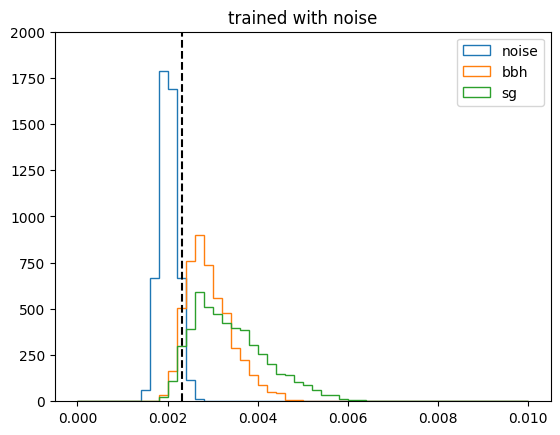

In [137]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [139]:
model

WSClassifier(
  (fc1): Linear(in_features=202, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

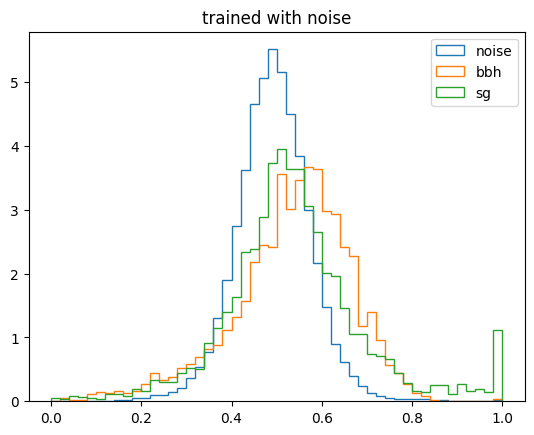

In [138]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [169]:
# This is the result for 0.1, 0.3, 0.3, 0.3

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[2 0 0 0]
0.0018406961178045514


In [160]:
listResult['cut'][np.argmin(listResult['FPR'])]

array([2, 0, 0, 0])

In [161]:
# This is the result for 0.05, 0.65, 0.15, 0.15


listResult['FPR'].min()

0.0010812480691998764

In [114]:
listResult['FPR']

array([[0.00269042],
       [0.00187459],
       [0.00153789],
       [0.00199332],
       [0.0018956 ],
       [0.00875379],
       [0.00812772],
       [0.00654907],
       [0.0080869 ],
       [0.00755668],
       [0.01912809],
       [0.02690304],
       [0.02102381],
       [0.02618812],
       [0.02710052],
       [0.09436454],
       [0.11363423],
       [0.19048077],
       [0.14568954],
       [0.20421925],
       [0.94098084],
       [0.80172659],
       [0.83388567],
       [0.92847232],
       [0.83878505],
       [0.00207975],
       [0.00171728],
       [0.00198234],
       [0.00180546],
       [0.00162455],
       [0.00651188],
       [0.00589837],
       [0.00599864],
       [0.00730059],
       [0.00866348],
       [0.015717  ],
       [0.02144241],
       [0.02421801],
       [0.01837318],
       [0.01809975],
       [0.09722724],
       [0.10327986],
       [0.0660505 ],
       [0.0818227 ],
       [0.10737527],
       [0.56803456],
       [0.62870952],
       [0.664

In [118]:
listResult['FPR'].max()

0.9409808421940138

In [117]:
listResult['cut'][np.argmax(listResult['FPR'])]

array([0, 4, 0, 0])

In [119]:
listResult['accuracy_4'][np.argmax(listResult['FPR'])]

array([1.        , 0.53942222, 0.659     , 0.47433333])

In [140]:
listResult['accuracy_4'][np.argmin(listResult['FPR'])]

array([0.99733333, 0.99364444, 0.94333333, 0.74933333])

In [141]:
listResult['cut'][np.argmin(listResult['FPR'])]

array([2, 0, 0, 0])

In [92]:
listResult['FPR']

array([[0.00358823],
       [0.00274416],
       [0.00272489],
       [0.00274773],
       [0.00242937],
       [0.00988634],
       [0.01039433],
       [0.00900642],
       [0.0100362 ],
       [0.00973696],
       [0.02253335],
       [0.03135414],
       [0.02714126],
       [0.029178  ],
       [0.03294916],
       [0.09553758],
       [0.11984214],
       [0.21123303],
       [0.15038797],
       [0.22227444],
       [0.93027594],
       [0.78834793],
       [0.84132243],
       [0.92044068],
       [0.83323382],
       [0.00271564],
       [0.00244283],
       [0.00307713],
       [0.00314827],
       [0.00230423],
       [0.00889728],
       [0.00782899],
       [0.00889783],
       [0.00998004],
       [0.01083424],
       [0.02235911],
       [0.02713663],
       [0.02823977],
       [0.02327639],
       [0.02240195],
       [0.10360711],
       [0.11741762],
       [0.07323506],
       [0.09423533],
       [0.11249449],
       [0.55623881],
       [0.62470752],
       [0.657

In [95]:
listResult['cut']

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 2, 0],
       [0, 0, 3, 0],
       [0, 0, 4, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 2, 0],
       [0, 1, 3, 0],
       [0, 1, 4, 0],
       [0, 2, 0, 0],
       [0, 2, 1, 0],
       [0, 2, 2, 0],
       [0, 2, 3, 0],
       [0, 2, 4, 0],
       [0, 3, 0, 0],
       [0, 3, 1, 0],
       [0, 3, 2, 0],
       [0, 3, 3, 0],
       [0, 3, 4, 0],
       [0, 4, 0, 0],
       [0, 4, 1, 0],
       [0, 4, 2, 0],
       [0, 4, 3, 0],
       [0, 4, 4, 0],
       [1, 0, 0, 0],
       [1, 0, 1, 0],
       [1, 0, 2, 0],
       [1, 0, 3, 0],
       [1, 0, 4, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 0],
       [1, 1, 2, 0],
       [1, 1, 3, 0],
       [1, 1, 4, 0],
       [1, 2, 0, 0],
       [1, 2, 1, 0],
       [1, 2, 2, 0],
       [1, 2, 3, 0],
       [1, 2, 4, 0],
       [1, 3, 0, 0],
       [1, 3, 1, 0],
       [1, 3, 2, 0],
       [1, 3, 3, 0],
       [1, 3, 4, 0],
       [1, 4, 0, 0],
       [1, 4, 1, 0],
       [1, 4,

In [ ]:
listResult['FPR'][np.argwhere()]

In [93]:
listResult["accuracy_4"]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ],
       [1.        , 0.94086667, 0.95      , 0.69725   ],
       [0.998     , 0.95153333, 0.9175    , 0.716     ],
       [0.999     , 0.9555    , 0.9215    , 0.71875   ],
       [0.9995    , 0.9578    , 0.92225   , 0.6985    ],
       [0.9995    , 0.89296667, 0.946     , 0.74725   ],
       [1.        , 0.87213333, 0.95225   , 0.7635    ],
       [0.9995    , 0.89996667, 0.946     , 0.76525   ],
       [0.9995    , 0.89676667, 0.9495    , 0.78025   ],
       [0.999     , 0.92576667, 0.94      , 0.74075   ],
       [0.9985    , 0.7336    , 0.975     , 0.8265    ],
       [0.9995    , 0.72283333, 0.9705    , 0.7655    ],
       [0.9995    , 0.72543333, 0.9775    , 0.78125   ],
       [0.999     , 0.77806667, 0.965     , 0.7505    ],
       [0.9995    , 0.74486667, 0.96875   , 0.7785    ],
       [0.9995    , 0.64096667, 0.96375   , 0.82125   ],
       [0.9995    , 0.57523333, 0.96025   , 0.7525    ],
       [0.9995    , 0.6028    ,

In [78]:
listResult["accuracy_4"]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ],
       [1.        , 0.94086667, 0.95      , 0.69725   ],
       [0.998     , 0.95153333, 0.9175    , 0.716     ],
       [0.999     , 0.9555    , 0.9215    , 0.71875   ],
       [0.9995    , 0.9578    , 0.92225   , 0.6985    ],
       [0.9995    , 0.89296667, 0.946     , 0.74725   ],
       [1.        , 0.87213333, 0.95225   , 0.7635    ],
       [0.9995    , 0.89996667, 0.946     , 0.76525   ],
       [0.9995    , 0.89676667, 0.9495    , 0.78025   ],
       [0.999     , 0.92576667, 0.94      , 0.74075   ],
       [0.9985    , 0.7336    , 0.975     , 0.8265    ],
       [0.9995    , 0.72283333, 0.9705    , 0.7655    ],
       [0.9995    , 0.72543333, 0.9775    , 0.78125   ],
       [0.999     , 0.77806667, 0.965     , 0.7505    ],
       [0.9995    , 0.74486667, 0.96875   , 0.7785    ],
       [0.9995    , 0.64096667, 0.96375   , 0.82125   ],
       [0.9995    , 0.57523333, 0.96025   , 0.7525    ],
       [0.9995    , 0.6028    ,

In [89]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

Text(0, 0.5, 'percentage')

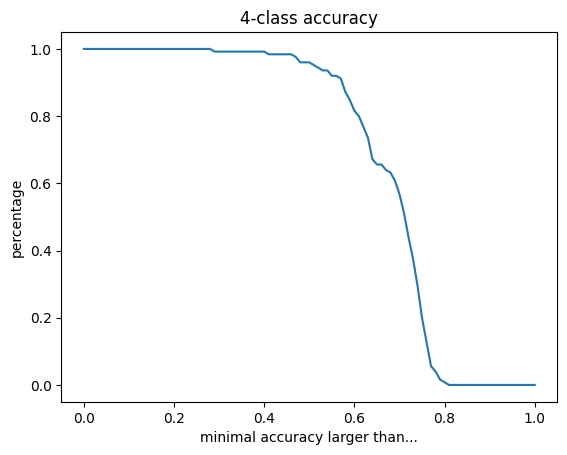

In [178]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

Text(0, 0.5, 'percentage')

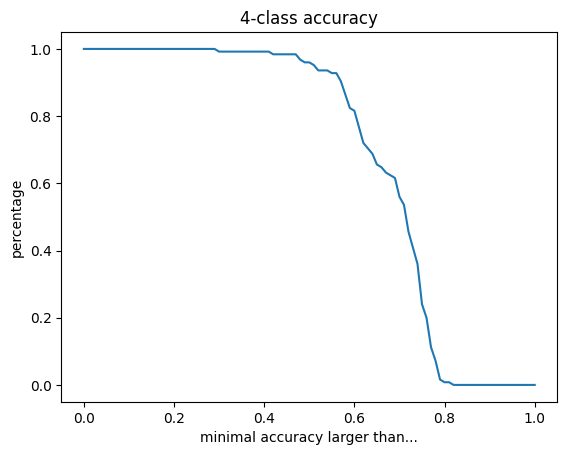

In [81]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [83]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.998     , 0.94366667, 0.95925   , 0.81125   ]])

In [180]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

### Below is the analysis for the most accuracy 

In [184]:
listResult["total_accuracy"].max()

0.9654666666666667

In [181]:
listResult["cut"][np.argmax(listResult["total_accuracy"]).flatten()]

array([[4, 0, 0, 0]])

In [242]:
np.argmax(listResult["total_accuracy"]).flatten()

array([23], dtype=int64)

In [182]:
listResult["accuracy_4"][np.argmax(listResult["total_accuracy"]).flatten()]

array([[0.99466667, 0.9952    , 0.927     , 0.76633333]])

In [ ]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")

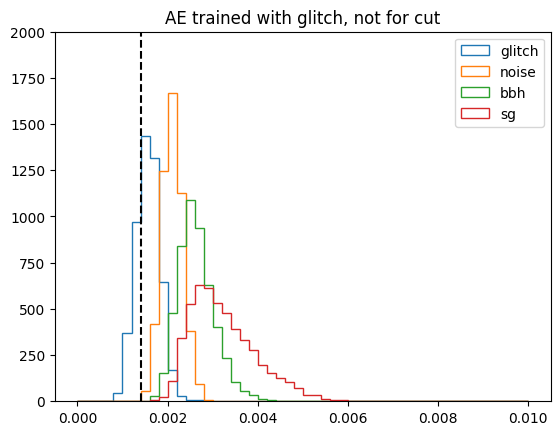

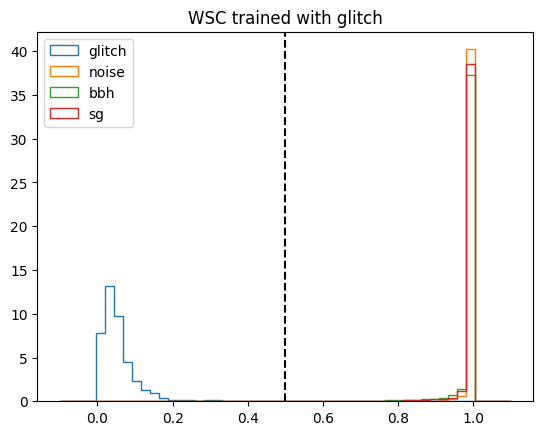

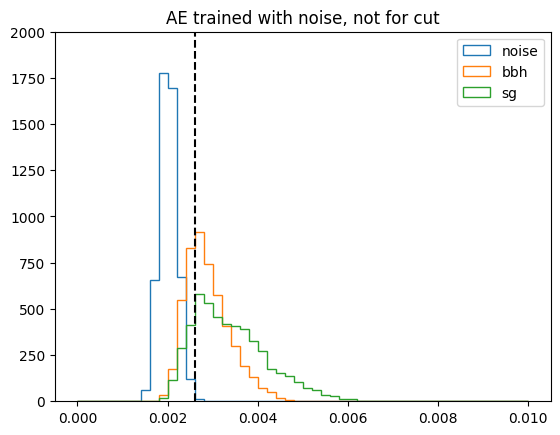

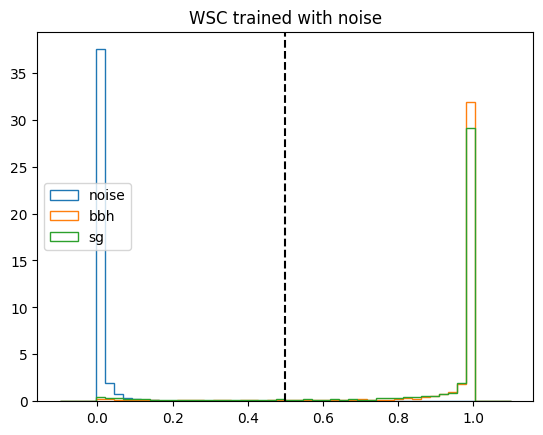

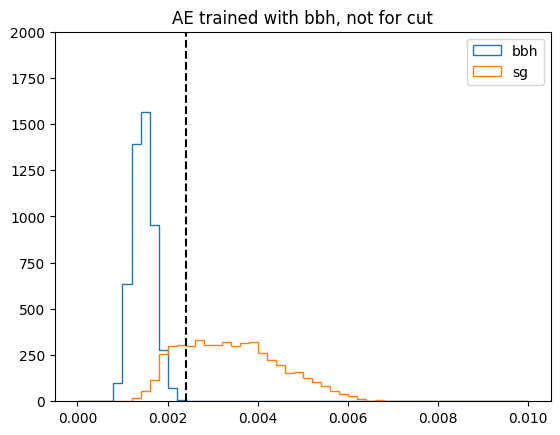

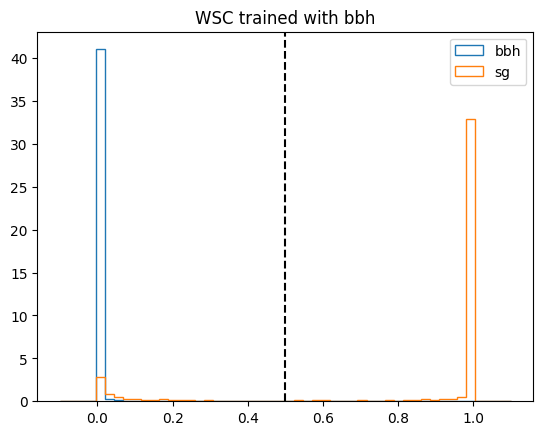

In [197]:
dcd = {};
err = {};
ans = np.zeros(len(testset), dtype="int")

ic = [4,0,0,0]


models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")

for datatype in list_datatype:
    if datatype == 'sg':
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
    else:
        dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
not_select = np.array([True]*len(testset));

for iStep in range(len(list_datatype)-1):
    datatype = ind2datatype[iStep];
    if datatype == 'sg':
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    else:
        ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
        
    # if datatype == 'noise':
    #     ind_pass_fprcalc = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        # noise_number = np.sum(np.logical_and(not_select, correct_ans == 1))
        # passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass_fprcalc, correct_ans == 1))
        # listResult['FPR'][cnt] = passed_noise_number / noise_number
        # print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    
    plotting_set= {}
    
    plotting_set['glitch'] = testset[np.logical_and(not_select, correct_ans == 0)]
    plotting_set['noise'] = testset[np.logical_and(not_select, correct_ans == 1)]
    plotting_set['bbh'] = testset[np.logical_and(not_select, correct_ans == 2)]
    plotting_set['sg'] = testset[np.logical_and(not_select, correct_ans == 3)]
    
    # AE plotting
    
    for j in range(iStep, 4):
        
        type = ind2datatype[j]
    
        dcd_ae = models[datatype](torch.FloatTensor(plotting_set[type]))[1].detach().numpy()
        err_ae = np.var(plotting_set[type]-dcd_ae, axis=1)
    
        foo = plt.hist(err_ae, histtype="step", range=(0, 0.01), bins=50, density=True, label=type)
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("AE trained with " + datatype + ", not for cut")
    plt.axvline(cutList[datatype][ic[iStep]], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.ylim(0,2000)
    plt.show()
    
    # WSC plotting
    
    for j in range(iStep,4):
        
        type = ind2datatype[j]
    
    
        dcd_wsc = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(plotting_set[type]))).detach().numpy()

        foo = plt.hist(dcd_wsc, histtype="step", range=(-0.1, 1.1), bins=50, density=True, label=type)
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("WSC trained with " + datatype)
    plt.axvline(0.5, color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    # plt.ylim(0,2000)
    plt.show()
    
    ans[ind_pass] = iStep;
    not_select[ind_pass] = False;
    
ans[not_select] = -1;

In [205]:
flag = 2

print(np.sum(ans == flag))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)) / np.sum(ans == flag))

3193
2781
0.8709677419354839


In [ ]:
np.sum(ans == 0)

In [187]:
ind2datatype

{0: 'glitch', 1: 'noise', 2: 'bbh', 3: 'sg'}

### Below is the analysis for the most balanced accuracy 

In [179]:
listResult["cut"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[1, 1, 0, 0]])

In [183]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.99933333, 0.94342222, 0.96733333, 0.80966667]])

In [94]:
listResult["FPR"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.00889728]])

(1500, 202)


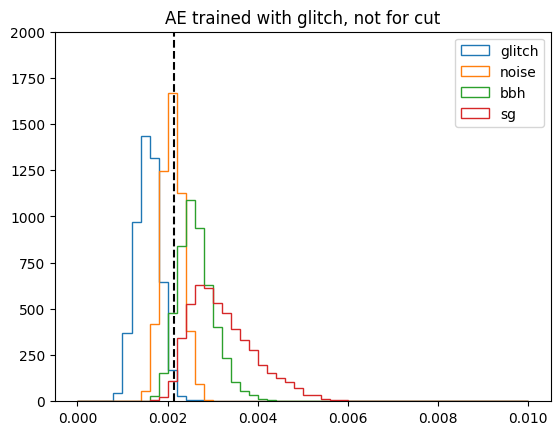

6.3194386e-07
0.0006726528
0.114714034
0.031452436


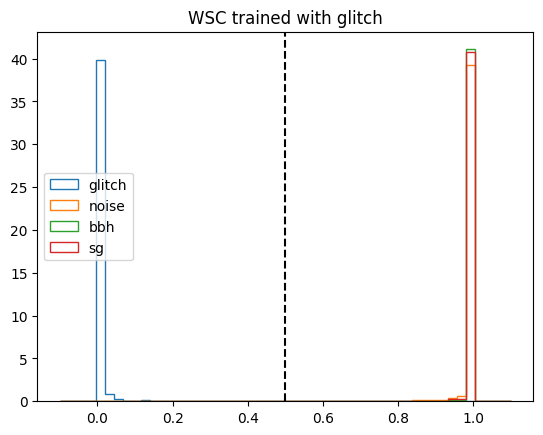

(1, 202)


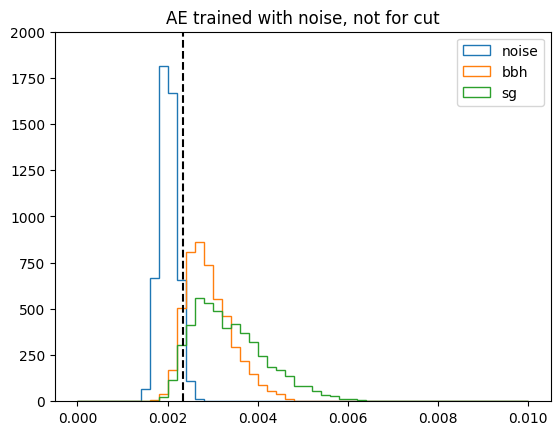

6.01449e-05
0.003197677
0.015284974


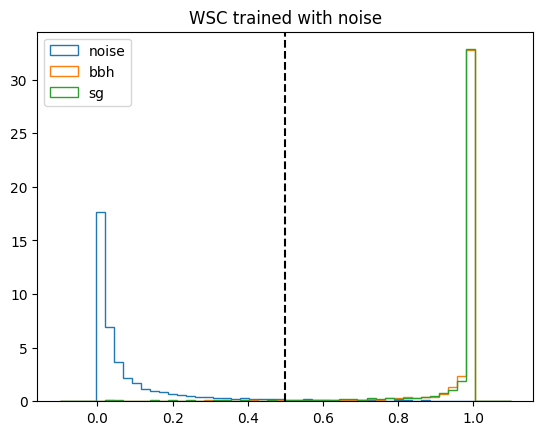

(1, 202)


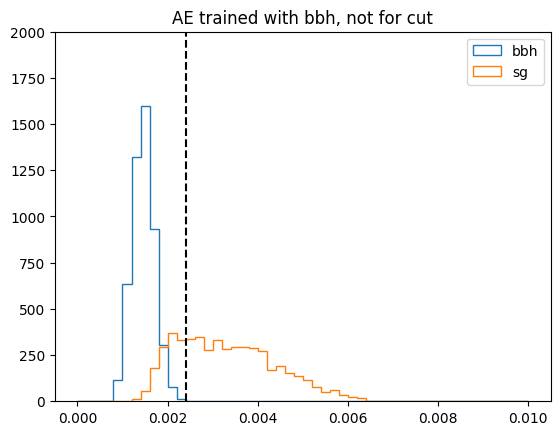

2.1962258e-07
4.5052416e-06


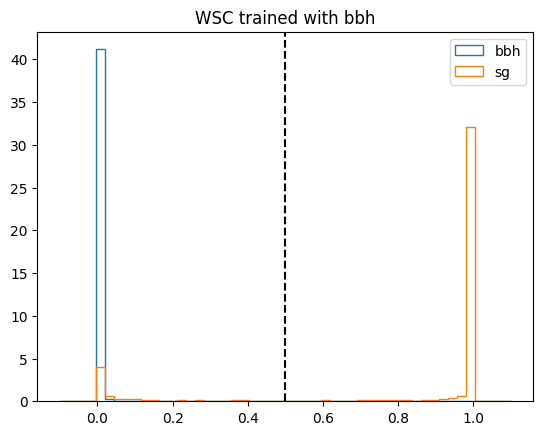

In [209]:
dcd = {};
err = {};
ans = np.zeros(len(testset), dtype="int")

ic = [1,1,0,0]


models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")

for datatype in list_datatype:
    if datatype == 'sg':
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
    else:
        dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
not_select = np.array([True]*len(testset));

for iStep in range(len(list_datatype)-1):
    datatype = ind2datatype[iStep];
    if datatype == 'sg':
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    else:
        ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
        
    # if datatype == 'noise':
    #     ind_pass_fprcalc = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        # noise_number = np.sum(np.logical_and(not_select, correct_ans == 1))
        # passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass_fprcalc, correct_ans == 1))
        # listResult['FPR'][cnt] = passed_noise_number / noise_number
        # print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    
    plotting_set= {}
    
    plotting_set['glitch'] = testset[np.logical_and(not_select, correct_ans == 0)]
    plotting_set['noise'] = testset[np.logical_and(not_select, correct_ans == 1)]
    plotting_set['bbh'] = testset[np.logical_and(not_select, correct_ans == 2)]
    plotting_set['sg'] = testset[np.logical_and(not_select, correct_ans == 3)]
    print(plotting_set['glitch'].shape)
    
    # AE plotting
    
    for j in range(iStep, 4):
        
        type = ind2datatype[j]
    
        dcd_ae = models[datatype](torch.FloatTensor(plotting_set[type]))[1].detach().numpy()
        err_ae = np.var(plotting_set[type]-dcd_ae, axis=1)
    
        foo = plt.hist(err_ae, histtype="step", range=(0, 0.01), bins=50, density=True, label=type)
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("AE trained with " + datatype + ", not for cut")
    plt.axvline(cutList[datatype][ic[iStep]], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.ylim(0,2000)
    plt.show()
    
    # WSC plotting
    
    for j in range(iStep,4):
        
        type = ind2datatype[j]
    
    
        dcd_wsc = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(plotting_set[type]))).detach().numpy()

        foo = plt.hist(dcd_wsc, histtype="step", range=(-0.1, 1.1), bins=50, density=True, label=type)
        
        print(dcd_wsc.min())
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("WSC trained with " + datatype)
    plt.axvline(0.5, color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    # plt.ylim(0,2000)
    plt.show()
    
    ans[ind_pass] = iStep;
    not_select[ind_pass] = False;
    
ans[not_select] = -1;

In [211]:
flag = 2

print(np.sum(ans == flag))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)) / np.sum(ans == flag))

3491
2902
0.831280435405328


### Below is the analysis for the least TPR

In [185]:
listResult["cut"][np.argmin(listResult["FPR"]).flatten()]

array([[2, 0, 0, 0]])

In [221]:
listResult["accuracy_4"][np.argmin(listResult["FPR"]).flatten()]

array([[0.99733333, 0.99364444, 0.94333333, 0.74933333]])

In [213]:
listResult["FPR"].min()

0.0012943539388529347

(1500, 202)


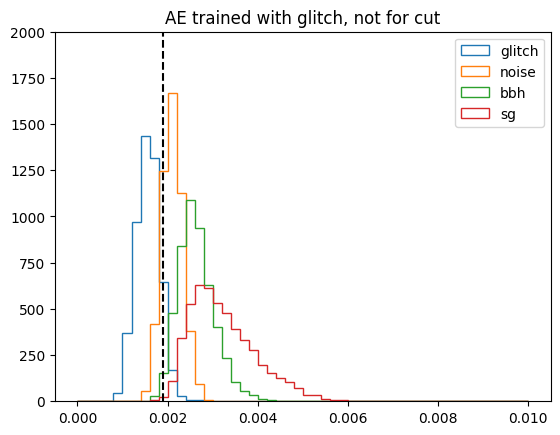

1.848859e-07
2.4323588e-05
0.1328285
0.023303123


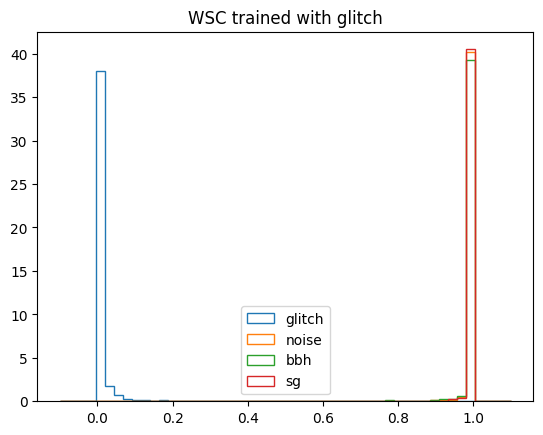

For cnt = 125, totally 22405 noise events passed the glitch WSL, and 29 noise events within the threshold for TPR=0.9
(4, 202)


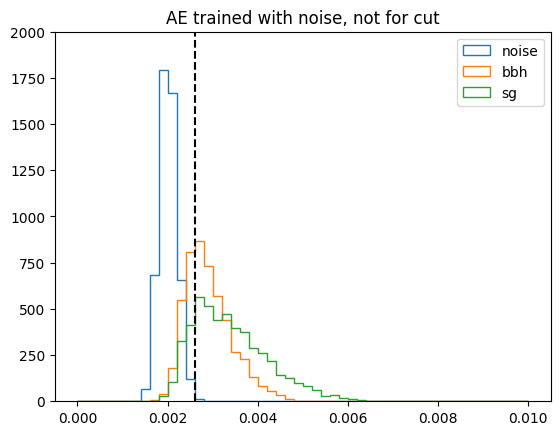

3.383567e-06
0.0010596163
0.0007986854


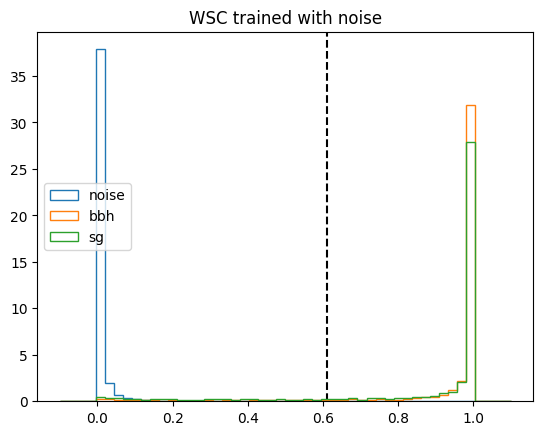

(2, 202)


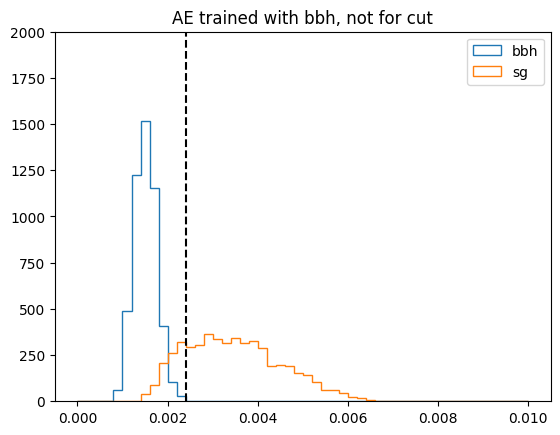

4.0121744e-08
9.435539e-07


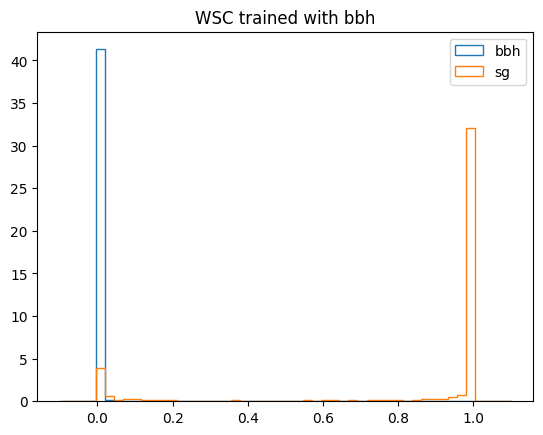

In [219]:
dcd = {};
err = {};
ans = np.zeros(len(testset), dtype="int")

ic = [2,0,0,0]


models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")

for datatype in list_datatype:
    if datatype == 'sg':
        dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        err[datatype] = np.var(testset-dcd[datatype], axis=1)
    else:
        dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
    
not_select = np.array([True]*len(testset));

for iStep in range(len(list_datatype)-1):
    datatype = ind2datatype[iStep];
    if datatype == 'sg':
        ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    else:
        ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
        
    if datatype == 'noise':
        threshold = np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))]
        ind_pass_fprcalc = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
        noise_number = np.sum(np.logical_and(not_select, correct_ans == 1))
        passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass_fprcalc, correct_ans == 1))
        # listResult['FPR'][cnt] = passed_noise_number / noise_number
        print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    
    plotting_set= {}
    
    plotting_set['glitch'] = testset[np.logical_and(not_select, correct_ans == 0)]
    plotting_set['noise'] = testset[np.logical_and(not_select, correct_ans == 1)]
    plotting_set['bbh'] = testset[np.logical_and(not_select, correct_ans == 2)]
    plotting_set['sg'] = testset[np.logical_and(not_select, correct_ans == 3)]
    print(plotting_set['glitch'].shape)
    
    # AE plotting
    
    for j in range(iStep, 4):
        
        type = ind2datatype[j]
    
        dcd_ae = models[datatype](torch.FloatTensor(plotting_set[type]))[1].detach().numpy()
        err_ae = np.var(plotting_set[type]-dcd_ae, axis=1)
    
        foo = plt.hist(err_ae, histtype="step", range=(0, 0.01), bins=50, density=True, label=type)
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("AE trained with " + datatype + ", not for cut")
    plt.axvline(cutList[datatype][ic[iStep]], color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    plt.ylim(0,2000)
    plt.show()
    
    # WSC plotting
    
    for j in range(iStep,4):
        
        type = ind2datatype[j]
    
    
        dcd_wsc = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(plotting_set[type]))).detach().numpy()

        foo = plt.hist(dcd_wsc, histtype="step", range=(-0.1, 1.1), bins=50, density=True, label=type)
        
        print(dcd_wsc.min())
        
        if iStep == 1 and j == 1:
            plt.axvline(threshold, color = 'k', linestyle = '--')
        
    # foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
    plt.title("WSC trained with " + datatype)
    # plt.axvline(, color="k", linestyle="--")
    # plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
    plt.legend()
    # plt.ylim(0,2000)
    plt.show()
    
    ans[ind_pass] = iStep;
    not_select[ind_pass] = False;
    
ans[not_select] = -1;

In [222]:
flag = 1

print(np.sum(ans == flag))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)))
print(np.sum(np.logical_and(ans == flag, correct_ans == flag)) / np.sum(ans == flag))

22856
22357
0.9781676583829192


Text(0, 0.5, 'percentage')

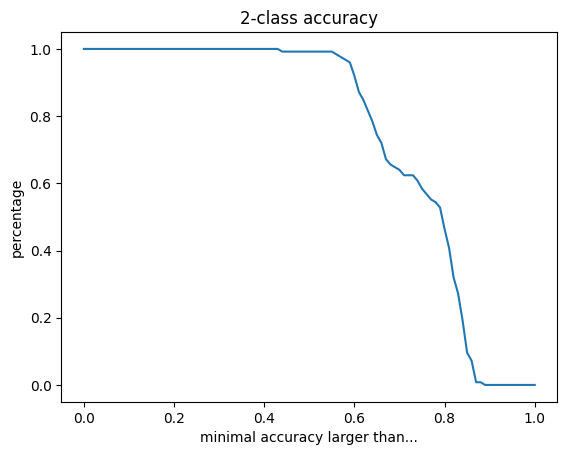

In [82]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [84]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

In [87]:
listResult['total_accuracy'].max()

0.96345

In [88]:
listResult["accuracy_4"][np.argmax(listResult["accuracy_4"]>0.8).flatten()]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ]])

In [66]:
np.argwhere(np.all(np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)))) == np.array([3,1,3]), axis = 1))

array([[83]], dtype=int64)

In [62]:
np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 2, 4],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [0, 3, 4],
       [0, 4, 0],
       [0, 4, 1],
       [0, 4, 2],
       [0, 4, 3],
       [0, 4, 4],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 0, 4],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 0],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 0, 4],
       [2,

In [73]:
ic

array([4, 4, 4, 4])

In [49]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}